Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.041019 s



c:\Users\basan\Anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.037610 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [6.70e+00, 0.00e+00, 5.78e-01, 1.27e-01, 7.47e-02]    [6.93e+00, 0.00e+00, 5.78e-01, 1.27e-01, 7.47e-02]    [7.04e+00]    
1000      [7.59e-03, 4.52e-07, 2.16e-04, 3.33e-03, 4.30e-04]    [4.86e-03, 4.52e-07, 2.16e-04, 3.33e-03, 4.30e-04]    [3.10e-01]    
2000      [4.82e-04, 2.68e-08, 6.05e-07, 1.29e-05, 5.79e-07]    [3.49e-04, 2.68e-08, 6.05e-07, 1.29e-05, 5.79e-07]    [1.38e-02]    
3000      [1.64e-05, 1.08e-11, 2.03e-09, 1.99e-08, 6.71e-09]    [2.22e-05, 1.08e-11, 2.03e-09, 1.99e-08, 6.71e-09]    [1.24e-03]    
4000      [1.23e-05, 3.04e-13, 4.55e-10, 7.96e-09, 1.13e-09]    [1.68e-05, 3.04e-13, 4.55e-10, 7.96e-09, 1.13e-09]    [9.86e-04]    
5000      [1.13e-05, 8.68e-09, 2.39e-08, 1.55e-08, 1.65e-07]    [1.45e-05, 8.68e-09, 2.39e-08, 1.55e-08, 1.65e-07]    [3.86e-03]    
6000      [8.31e-06, 1.

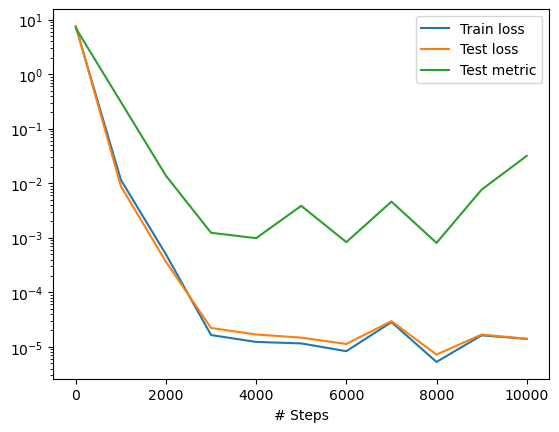

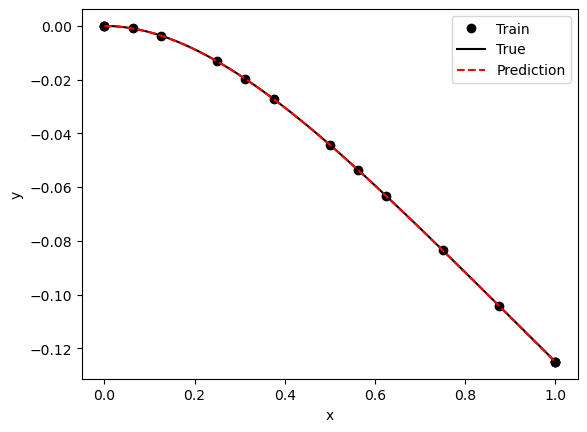

In [2]:
import deepxde as dde
import numpy as np

def ddy(x, y):
    return dde.grad.hessian(y, x)

def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

def pde(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + 1

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def func(x):
    return -(x**4) / 24 + x**3 / 6 - x**2 / 4

geom = dde.geometry.Interval(0, 1)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
bc3 = dde.icbc.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)

data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=10,
    num_boundary=2,
    solution=func,
    num_test=100,
)

layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)